In [32]:
# Standard Libraries

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# For Web Scrapping
import requests
from bs4 import BeautifulSoup

# For Data Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer   
from textblob import Word, TextBlob
from wordcloud import WordCloud , STOPWORDS

# For topic modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation

# For sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Extracting reviews from "Skytrax" website

In [33]:
website = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10              # Total no. of pages selected for review extraction
page_size = 100          

reviews = []            # object to store extracted reviews from website

for i in range(1, pages + 1):      

    print(f"Scraping data from Page {i}")

    # Create URL to collect links 
    url = f"{website}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    
    response = requests.get(url)     # Collect HTML data from this page

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} Total Reviews")

Scraping data from Page 1
   ---> 100 Total Reviews
Scraping data from Page 2
   ---> 200 Total Reviews
Scraping data from Page 3
   ---> 300 Total Reviews
Scraping data from Page 4
   ---> 400 Total Reviews
Scraping data from Page 5
   ---> 500 Total Reviews
Scraping data from Page 6
   ---> 600 Total Reviews
Scraping data from Page 7
   ---> 700 Total Reviews
Scraping data from Page 8
   ---> 800 Total Reviews
Scraping data from Page 9
   ---> 900 Total Reviews
Scraping data from Page 10
   ---> 1000 Total Reviews


In [34]:
# Storing reviews in a pandas dataframe 
df = pd.DataFrame()               
df["reviews"] = reviews             
df.head()

,reviews
0,✅ Trip Verified | While BA may have made some...
1,✅ Trip Verified | British Airways new Club Sui...
2,"✅ Trip Verified | Four very pleasant, on time..."
3,Not Verified | We travel extensively over 25...
4,✅ Trip Verified | Flight delayed an hour due ...


# 1. Text Preprocessing

## 1.1.Removing the symbol " | " 

In [35]:
df.reviews= df.reviews.str.split('|',expand=True)[1]          # it will split the text before and after the symbol

In [36]:
df.head()

,reviews
0,While BA may have made some positive improve...
1,British Airways new Club Suite is a marked im...
2,"Four very pleasant, on time flights with fri..."
3,We travel extensively over 25 years and ten...
4,Flight delayed an hour due to bad weather ar...


## 1.2.Regular Expressions

#### sub() function belongs to the Regular Expressions ( re ) module in Python. 
#### It returns a string where all matching occurrences of the specified pattern are replaced by required string or blanks.

In [37]:
def replace(text):            # Define a function to clean the text
    text = re.sub(r'[^A-Za-z]+', ' ', str(text)) # Replaces all special characters and numericals with blanks and leaving the alphabets
    return text
# Cleaning the text in the review column
df['reviews']= df["reviews"].apply(replace)
df.head()

,reviews
0,While BA may have made some positive improvem...
1,British Airways new Club Suite is a marked im...
2,Four very pleasant on time flights with frien...
3,We travel extensively over years and tend to ...
4,Flight delayed an hour due to bad weather aro...


## 1.3.Converting into Lower Case

In [38]:
df['reviews'] = df['reviews'].str.lower()

In [39]:
df.head()

,reviews
0,while ba may have made some positive improvem...
1,british airways new club suite is a marked im...
2,four very pleasant on time flights with frien...
3,we travel extensively over years and tend to ...
4,flight delayed an hour due to bad weather aro...


## 1.4.Removing Punctuations

In [40]:
df['reviews'] = df['reviews'].str.replace('[^\w\s]', '')

In [41]:
df.head()

,reviews
0,while ba may have made some positive improvem...
1,british airways new club suite is a marked im...
2,four very pleasant on time flights with frien...
3,we travel extensively over years and tend to ...
4,flight delayed an hour due to bad weather aro...


## 1.5.Removing Numbers

In [42]:
df['reviews'] = df['reviews'].str.replace('\d', '')

In [43]:
df.head()

,reviews
0,while ba may have made some positive improvem...
1,british airways new club suite is a marked im...
2,four very pleasant on time flights with frien...
3,we travel extensively over years and tend to ...
4,flight delayed an hour due to bad weather aro...


## 1.6.Word Tokenization

In [44]:
df["reviews"].apply(lambda x: TextBlob(x).words).head()

0    [while, ba, may, have, made, some, positive, i...
1    [british, airways, new, club, suite, is, a, ma...
2    [four, very, pleasant, on, time, flights, with...
3    [we, travel, extensively, over, years, and, te...
4    [flight, delayed, an, hour, due, to, bad, weat...
Name: reviews, dtype: object

## 1.7.Removing Stopwords

In [45]:
sw = stopwords.words('english')
df['reviews'] = df['reviews'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [46]:
df.head()

,reviews
0,ba may made positive improvements club world p...
1,british airways new club suite marked improvem...
2,four pleasant time flights friendly helpful st...
3,travel extensively years tend use ba regular t...
4,flight delayed hour due bad weather around jfk...


## 1.8.Lemmatization

In [47]:
df['reviews'] = df['reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviews'].head(10)

0    ba may made positive improvement club world pr...
1    british airway new club suite marked improveme...
2    four pleasant time flight friendly helpful sta...
3    travel extensively year tend use ba regular tr...
4    flight delayed hour due bad weather around jfk...
5    full flight made premium economy feel little l...
6    worst airline ever flown could check flight op...
7    surprised able give favourable review flight e...
8    flew british airway ba london heathrow amsterd...
9    ba cancelled flight tokyo lhr booked next day ...
Name: reviews, dtype: object

In [48]:
df.head()

,reviews
0,ba may made positive improvement club world pr...
1,british airway new club suite marked improveme...
2,four pleasant time flight friendly helpful sta...
3,travel extensively year tend use ba regular tr...
4,flight delayed hour due bad weather around jfk...


# 2.Topic Modeling 

#### The Bag of Words approach - This approach uses the counts of words as a starting block and records the occurrence of each word (from the entire text) in a vector specific to that particular word.

In [49]:
cv = CountVectorizer()
x = cv.fit_transform(reviews)         # Fitting the vectorizer to the dataset

In [50]:
x

<1000x7740 sparse matrix of type '<class 'numpy.int64'>'
	with 95083 stored elements in Compressed Sparse Row format>

## 2.2.Implementing topic modelling techniques-Latent Dirichlet Allocation

#### Latent Dirichlet Allocation  
Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

In [51]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [52]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [53]:
lda.fit(x)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [55]:
# Assuming lda is your fitted LDA model and cv is your CountVectorizer
n_top_words = 40

# Function to print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print("\n")

# Get the feature names from the CountVectorizer
cv_feature_names = cv.get_feature_names_out()  # Note: use get_feature_names_out() if using a newer version of scikit-learn

# Print the topics
print("\nTopics in LDA model: ")
print_top_words(lda, cv_feature_names, n_top_words)


Topics in LDA model: 
Topic #0:
of first in on sad british to are the class and trip emirates ba experience very that comfort qatar is millions compensated if miles good fairness snug would satisfaction type one communicated leaking have from truly as was letzten be


Topic #1:
yielding odour forces smashed persistent lete oversubscribed ex unpleasant genuinely pieces dirty usually the lost eat ll to both is caused verified miss horrible luggage absolutely worst flights delivered was me and plans departure trip almost chatbot hour days multitude


Topic #2:
and the blend eclectic whispering stylish deference deprecation angel was quirky familiarity to fun classes my interesting with in ba on for exceptional modern of that 35 not various at delicious were relaxed food this self gates flight as presented


Topic #3:
the and was to in of on ba class gf is not flight business as crew no that it coasters mop they seat with we my biggest at so for but had intra service verified this you an 

### 2.3.Generating the wordcloud for the first 4 topics

In [56]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [57]:
first_topic_words = [cv_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [cv_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [cv_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [cv_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

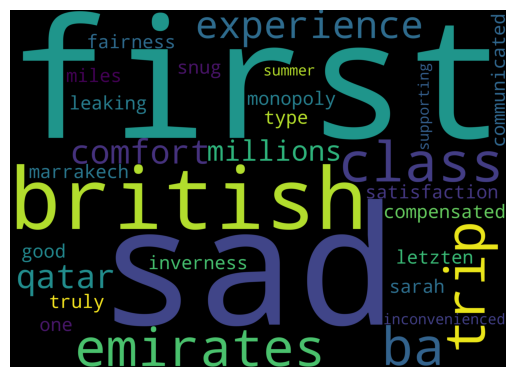

In [59]:
# Generating the wordcloud with the values for first topic
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

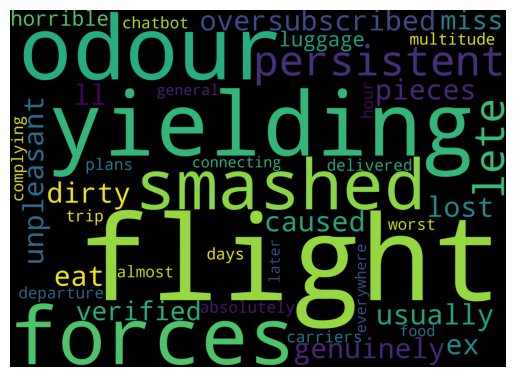

In [60]:
#Generating the wordcloud with the values for Second topic
secondcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

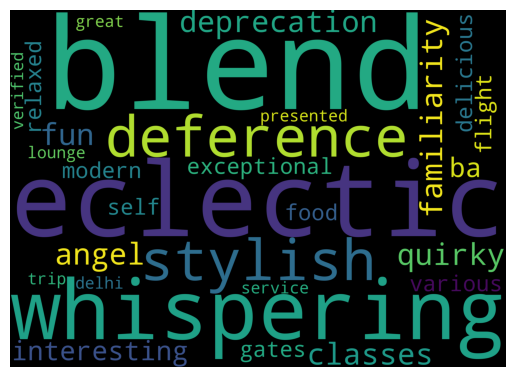

In [61]:
# Generating the wordcloud with the values for third topic
thirdcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

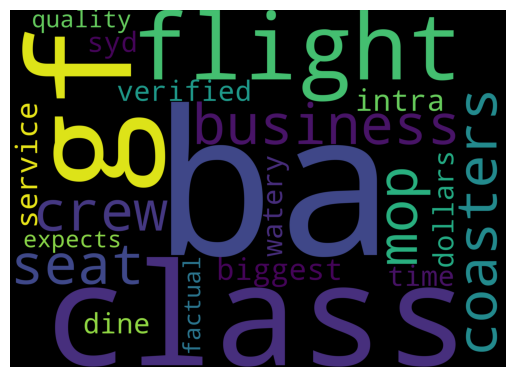

In [62]:
# Generating the wordcloud with the values for fouth topic
fourthcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words))
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()

# 3.Sentiment Analysis

#### *For Sentiment Analysis, we’ll use VADER Sentiment Analysis, where VADER means Valence Aware Dictionary and sentiment Reasoner.
#### *VADER not only tells about the Polarity score , in addition, it tells us how positive or negative a statement is.

In [63]:
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['reviews'].apply(vadersentimentanalysis)


def vader_analysis(compound):                
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,reviews,Sentiment,Analysis
0,ba may made positive improvement club world pr...,0.8267,Positive
1,british airway new club suite marked improveme...,0.6808,Positive
2,four pleasant time flight friendly helpful sta...,0.5759,Positive
3,travel extensively year tend use ba regular tr...,-0.4946,Negative
4,flight delayed hour due bad weather around jfk...,0.9653,Positive


In [64]:
analysis = df['Analysis'].value_counts()
analysis

Analysis
Positive    463
Negative    429
Neutral     108
Name: count, dtype: int64

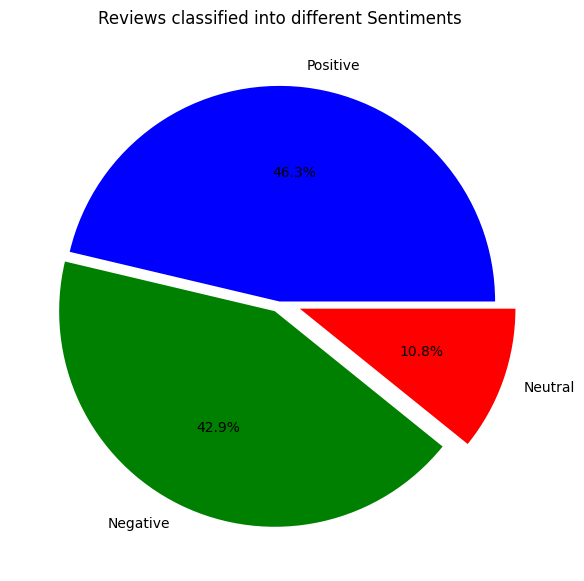

In [65]:
plt.figure(figsize=(25,7))
plt.subplot(1,3,2)
plt.title("Reviews classified into different Sentiments")
plt.pie(analysis.values, labels = analysis.index, explode = (0, 0.05, 0.1), autopct='%1.1f%%', shadow=False , colors=("blue", "green", "red"))
plt.show()

# 4.Text Visualization

## 4.1.Top 50 words with highest frequency in our dataset

In [68]:
all_words = df['reviews'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies in the dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## 4.2.WordCloud of our dataset

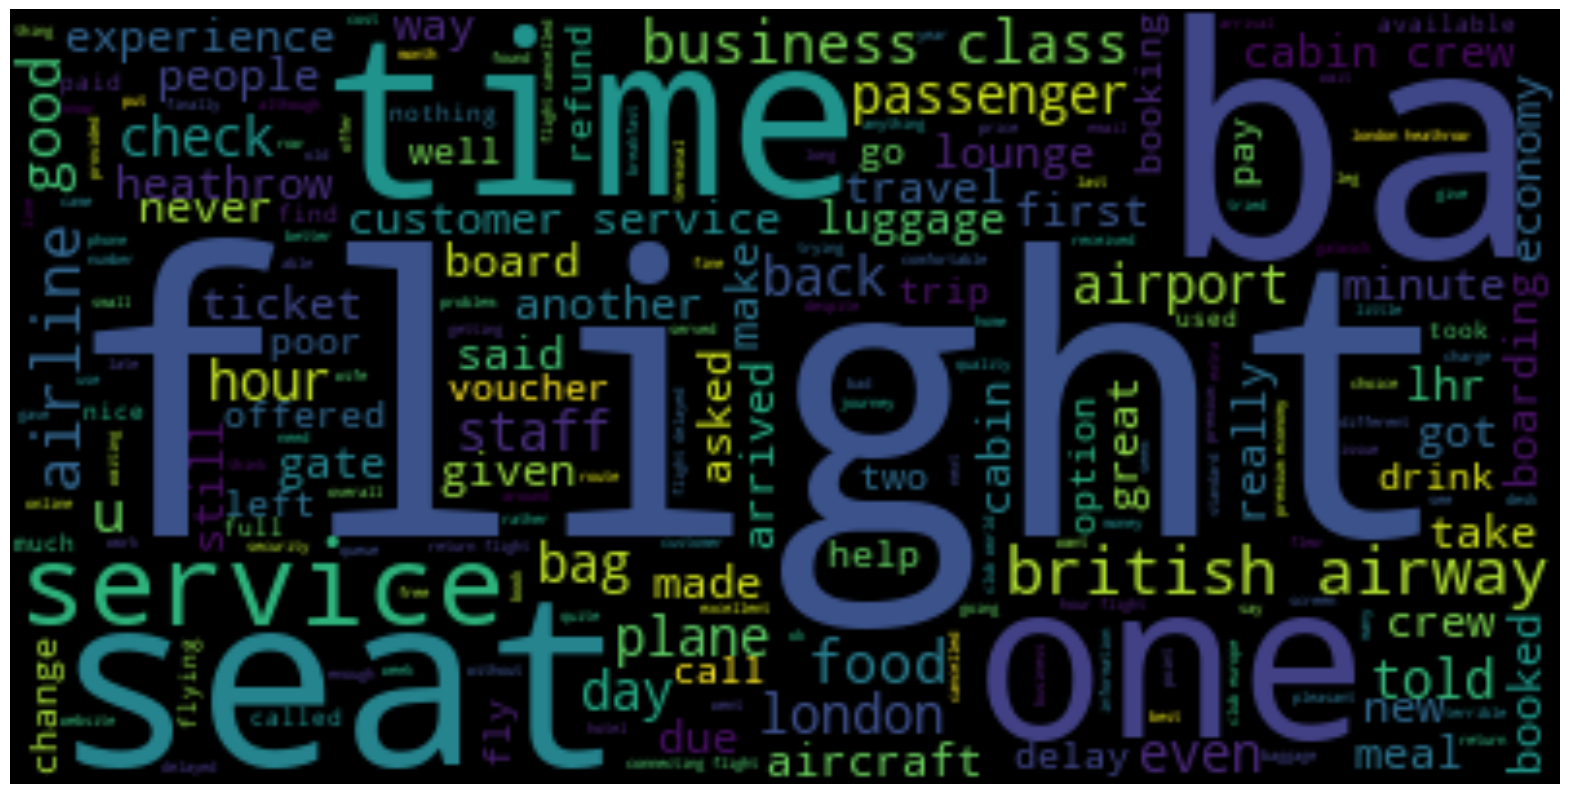

In [67]:
text = " ".join(i for i in df.reviews)
wordcloud = WordCloud().generate(text)
fig = plt.figure(1, figsize=(20, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()